# U-NET modeling

In [1]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import text_to_word_sequence
from sklearn.preprocessing import LabelEncoder

from keras import layers, models, optimizers
from keras import backend

import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2


In [2]:
class UNET(models.Model):
    def __init__(self, org_shape, n_ch):
        channel_index = 3 if backend.image_data_format() == 'channels_last' else 1
        
        def conv(x, n_f, mp_flag=True):
            x =layers.MaxPooling2D((2,2), padding='same')(x) if mp_flag else x
            x =layers.Conv2D(n_f, (3,3), padding='same')(x)
            x =layers.BatchNormalization()(x)
            x =layers.Activation('tanh')(x)
            x =layers.Conv2D(n_f, (3,3), padding='same')(x)
            x =layers.BatchNormalization()(x)
            x =layers.Activation('tanh')(x)
            return x
        def deconv_unet(x, e, n_f):
            x = layers.UpSampling2D((2,2))(x)
            x = layers.Concatenate(axis=channel_index)([x,e])
            x = layers.Conv2D(n_f, (3,3), padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('tanh')(x)
            x = layers.Conv2D(n_f, (3,3), padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('tanh')(x)
            return x
        
        original = layers.Input(shape=org_shape)
        
        c1 = conv(original, 16, False)
        c2 = conv(c1, 32)
        encoded = conv(c2, 64)
        
        x = deconv_unet(encoded, c2, 32)
        x = deconv_unet(x, c1, 16)
        decoded = layers.Conv2D(n_ch, (3,3), activation='sigmoid',padding='same')(x)
        
        super().__init__(original, decoded)
        self.compile(optimizer='adadelta', loss='mse')

In [4]:
image_path = glob.glob('/Users/sunghoheo/last_project/home_alone'+'/*')
def make_file(data_height, data_width, channel_n, batch_size):
    label = []
    images = np.zeros((batch_size, data_height, data_width, channel_n))
    for n, path in enumerate(image_path[:batch_size]):

    # lable 
        token = text_to_word_sequence(image_path[n])
        label.append(token[0])
        
    # image transform
        image = cv2.imread(image_path[n])
        image = cv2.resize(image, (data_height, data_width))/255
        images[n, :, :, :] =image
    
    label = np.array(label)
        
    return (label, images)

In [5]:
data_height = 256
data_width = 256
channel_n = 3
batch_size = len(image_path)

In [6]:
(label, images) = make_file(data_height, data_width, channel_n, batch_size)

In [7]:
items = label
encoder = LabelEncoder()
encoder.fit(items)
label = encoder.transform(items)

In [8]:
class DATA(): 
    def __init__(self):
        X_train, X_test, y_train, y_test = train_test_split(images, 
                                                    label, 
                                                    test_size=0.3, 
                                                    random_state=30)
        
        if backend.image_data_format() == 'channels_first':
            n_channel, image_rows, image_cols = X_train.shape[1:]
            input_shape = (1, image_rows, image_cols)
        else:
            image_rows,image_cols, n_channel = X_train.shape[1:]
            input_shape = (image_rows,image_cols, 1)
        
        X_train = X_train.astype('float32') / 255.0
        X_test = X_test.astype('float32') / 255.0
        
        def RGB2Gray(image, fmt):
            if fmt == 'channels_first':
                R = image[:, 0:1]
                G = image[:, 1:2]
                B = image[:, 2:3]
            else:
                R = image[..., 0:1]
                G = image[..., 1:2]
                B = image[..., 2:3]
            return 0.299 * R + 0.587 * G + 0.114 * B
        #컬러 사진을 흑백으로 변환하고 넣어줌.
        X_train_in = RGB2Gray(X_train, backend.image_data_format())
        X_test_in = RGB2Gray(X_test, backend.image_data_format())
        
        self.input_shape = input_shape
        self.X_train_in, self.X_train_out = X_train_in, X_train
        self.X_test_in, self.X_test_out = X_test_in, X_test
        self.n_channel = n_channel

In [9]:
#모델학습 하기
epochs=10
batch_size=120
data = DATA()
unet = UNET(data.input_shape, data.n_channel)
    
history = unet.fit(data.X_train_in, data.X_train_out,
                      epochs=epochs,
                      batch_size=batch_size,
                      shuffle=True,
                      validation_split=0.2,
                      verbose=2)


2022-01-06 18:40:26.805270: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-06 18:40:26.805656: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10
2/2 - 24s - loss: 0.2882 - val_loss: 0.2499
Epoch 2/10
2/2 - 23s - loss: 0.2878 - val_loss: 0.2514
Epoch 3/10
2/2 - 23s - loss: 0.2874 - val_loss: 0.2531
Epoch 4/10
2/2 - 23s - loss: 0.2871 - val_loss: 0.2549
Epoch 5/10
2/2 - 23s - loss: 0.2865 - val_loss: 0.2568
Epoch 6/10
2/2 - 23s - loss: 0.2862 - val_loss: 0.2588
Epoch 7/10
2/2 - 24s - loss: 0.2858 - val_loss: 0.2610
Epoch 8/10
2/2 - 24s - loss: 0.2855 - val_loss: 0.2632
Epoch 9/10
2/2 - 24s - loss: 0.2851 - val_loss: 0.2657
Epoch 10/10
2/2 - 25s - loss: 0.2847 - val_loss: 0.2682


In [10]:
unet.summary()

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________________

### 생각보다 손실율이 높은데 어떤식으로 나왔는지 확인하겠습니다.

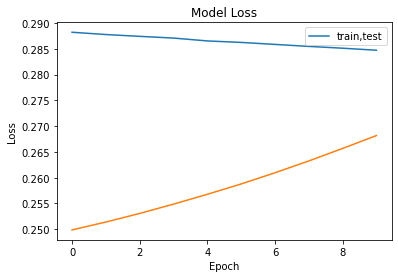

In [11]:
#다른 프로젝트 데이터도 넣으면 바로 사용할수있게끔 함수로 만듬.
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train,test'], loc=0)
    
plot_loss(history)

In [12]:
#image 복원 확인
def show_images(in_images, out_images, unet, sample_size=10):
    X_test_in = in_images[:sample_size]
    X_test_out = out_images[:sample_size]
    decoded_images = unet.predict(X_test_in, batch_size=sample_size)
    print("Before")
    print("X_test_in:", X_test_in.shape)
    print("decoded_images:", decoded_images.shape)
    print("X_test_out:", X_test_out.shape)
    
    if backend.image_data_format() == 'channels_first':
        X_test_out = X_test_out.swapaxex(1,3).swapaxes(1,2)
        decoded_images = decoded_images.swapaxes(1,3).swapaxes(1, 2)
        
        X_test_in = X_test_in[:, 0, ...]
    else:
        X_test_in = X_test_in[..., 0]
    
    print("After")
    print("X_test_in:", X_test_in.shape)
    print("decoded_images:", decoded_images.shape)
    print("X_test_out:", X_test_out.shape)
    
    plt.figure(figsize=(20,6))
    for i in range(sample_size):
        ax = plt.subplot(3, sample_size, i+1)
        plt.imshow(X_test_in[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, sample_size, i + 1 + sample_size)
        plt.imshow(decoded_images[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, sample_size, i + 1 + sample_size * 2)
        plt.imshow(X_test_out[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

Before
X_test_in: (10, 256, 256, 1)
decoded_images: (10, 256, 256, 3)
X_test_out: (10, 256, 256, 3)
After
X_test_in: (10, 256, 256)
decoded_images: (10, 256, 256, 3)
X_test_out: (10, 256, 256, 3)


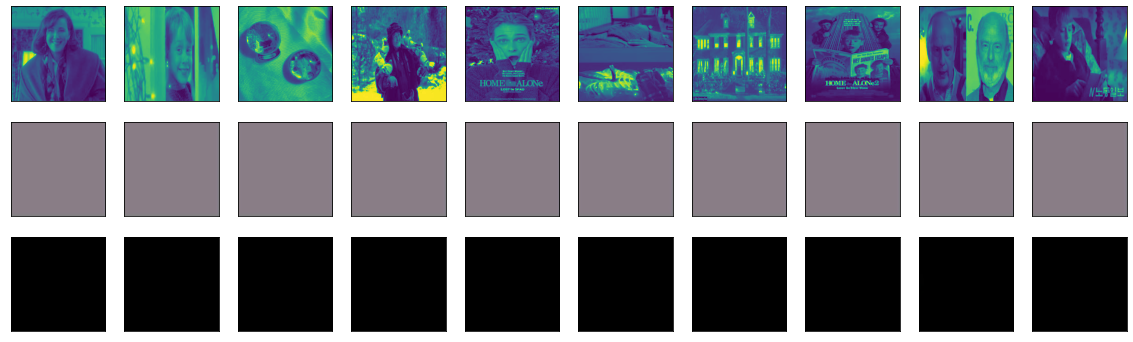

In [13]:
show_images(data.X_test_in, data.X_test_out, unet)

### CNN모델로 학습을한 이미지랑 달리 컬러로 복원은 50%이상이 컬러복원이 되었을줄 알았는데, 안되서 U-NET로 모델학습이 10%도 복원이 안된듯합니다.